In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Membrane channel dynamics

The Hodgkin-Huxley(HH) model can be seen as an extension of the RC-circuit model that in addition to a leakage channel contains channels for sodium (Na) and potassium (K). Ion channels are modeled as a resistor in series with a battery. The battery represents the equilibrium potential for the specific ion and the resistor reflects how permeable the channel is for that particular ion. In contrast to the fixed resistance of the leakage channel, the Na and K channel resistances have their own dynamics which depends on the voltage across the membrane. 

More precisely, for a given membrane potential there is a corresponding opening and closing rate for each channel. These opening and closing rates are described by alpha and beta functions that were empirically established by Hodgkin and Huxley. These alpha and beta functions are can be used in a differential equation that describes how the proportion of open channels changes over time:

$$
\frac{dn}{dt} = \alpha_n(V)(1-n) - \beta_n(V)n
$$

By rearranging terms in these equations we can determine, for a fixed membrane potential, what proportion of channels will be open (i.e., the steady state value $n_{\infty}$) and at what rate (i.e., the time constant $\tau_n$) the system will move to that proportion

$$
\tau_n = \frac{1}{\alpha_n + \beta_n}
$$

$$
n_{\infty} = \frac{\alpha_n}{\alpha_n + \beta_n}
$$

The code below calculates, for a range of voltage values, the alpha and beta functions. These values come from the following website: http://icwww.epfl.ch/~gerstner/SPNM/node14.html, which assumes that the resting potential equals 0 mV. The proportion of K channels is described by the $n$ variable and the proportion of Na channels is described by $m$ channels. The total conductance of a Na channel is in addition determined by a $h$ variable. Na channels are known to contain inactivation gates so that even when the channel itself is open, ionic current cannot flow if the inactivation gates block the channel. The $h$ variable then describes the proportion of inactivation gates that are open (i.e., not blocking the channel).

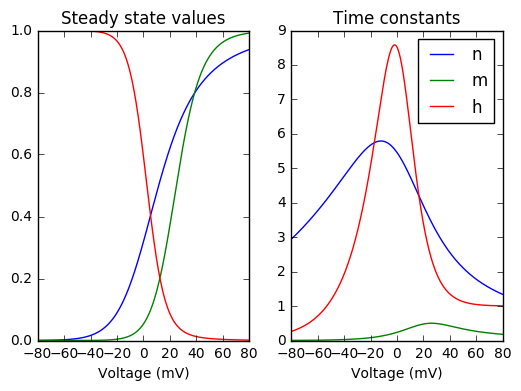

In [3]:
V = np.arange(-80.0,80,0.01) # [mV]

alpha_n = (0.1 - 0.01*V)/(np.exp(1-0.1*V)-1)
alpha_m = (2.5 - 0.1*V)/(np.exp(2.5 - 0.1*V)-1)
alpha_h = 0.07*np.exp(-V/20.0)

beta_n  = 0.125*np.exp(-V/80.0)
beta_m  = 4.0*np.exp(-V/18.0)
beta_h   = 1.0/(np.exp(3 - 0.1*V) + 1)

tau_n = 1/(alpha_n + beta_n)
inf_n = alpha_n*tau_n

tau_m = 1/(alpha_m + beta_m)
inf_m = alpha_m*tau_m 

tau_h = 1/(alpha_h + beta_h)
inf_h = alpha_h*tau_h

plt.clf()
plt.subplot(1,2,1)
plt.plot(V,inf_n)
plt.plot(V,inf_m)
plt.plot(V,inf_h)
plt.title('Steady state values')
plt.xlabel('Voltage (mV)')
plt.subplot(1,2,2)
plt.plot(V,tau_n)
plt.plot(V,tau_m)
plt.plot(V,tau_h)
plt.title('Time constants')
plt.xlabel('Voltage (mV)')
plt.legend(['n','m','h'])

The K gating variable $n$ shows that at equilibrium potential (remember that the current implementation assumes that the equilibrium potential is at zero) most of the K tend to be closed. As the membrane potential increases, channels start opening but with some delay. For Na channels the $m$ also increases when the membrane potential increases and the time constant indicates that changes are almost instantaneous. However, $h$ tends to decrease which tells us that at relatively high voltages a lot of Na channels will be open but there will be almost no ionic current because most of the channels are inactivated.

## 2. The full Hodgkin-Huxley model

The complete model is described by the following equation:

$$
-C_m\frac{dV}{dt} = g_L(V-E_L) + g_Kn^4(V-E_K) + g_{Na}m^3h(V-E_Na) - I_{extern}
$$

This equation contains a few additional parameters which we first define. Note that with the scale at which the values are expressed, our unit of time is in milliseconds. So the time-step for integration $dt$ is a lot smaller than the timestep we used for the passive membrane equation (0.01 versus 1 ms). This should be no surprise as the generation of an action potential contains a lot of interesting dynamics that occur at a very small timescale.

In [4]:
# Equilibrium potentials
E_Na = 115.0   # [mV]
E_K  = -12.0   # [mV]
E_L  = 10.6    # [mV]

# Maximal conductances
g_Na = 120.0   # [mS]
g_K  = 36.0    # [mS]
g_L  = 0.3     # [mS]

dt = 0.01      # [ms]
T = 40         # [ms]
t = np.arange(0,T,dt)

V = np.zeros(len(t))
n = np.zeros(len(t))
m = np.zeros(len(t))
h = np.zeros(len(t))

I_E = 0.0
V[0] = 0.0
h[0] = 0.59
m[0] = 0.05
n[0] = 0.31

In what follows we will numerically integrate these equatios for a scenario where we start at resting potential. Note that we have set the initial values for the gating variables equal to their corresponding steady state values that can be calculated from the alpha and beta functions. At 10 ms we start to apply a current 10 mA which is turned of again at 15 ms.

The integration has three main parts. First the value of the alpha and beta functions is calculated for the most recent membrane potential value. With these values we can calculate the time constants and steady state values that govern the dynamics of the gating variables and update these gating variables. The next step calculates the ionic current for Na, K and the leak channel taking into account the probability that each channel is open. The last step combines the ionic currents with any external currents and uses these to update the membrane potential.


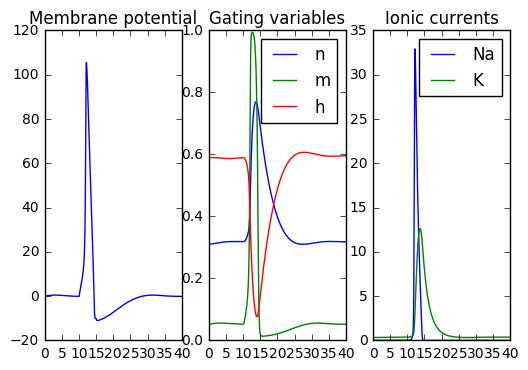

In [7]:
for i in range(1,len(t)):
    if i == 1000:
        I_E = 10.0
    if i == 1500:
        I_E = 0.0
        
    # Calculate the alpha and beta functions
    alpha_n = (0.1 - 0.01*V[i-1]) / ( np.exp(1   - 0.1*V[i-1]) - 1)
    alpha_m = (2.5 - 0.1 *V[i-1]) / ( np.exp(2.5 - 0.1*V[i-1]) - 1)
    alpha_h = 0.07*np.exp(-V[i-1]/20.0)
    
    beta_n = 0.125*np.exp(-V[i-1]/80.0)
    beta_m = 4.0 * np.exp(-V[i-1]/18.0)
    beta_h = 1 / ( np.exp(3 - 0.1*V[i-1]) + 1)
    
    # Calculate the time constants and steady state values
    tau_n = 1.0/(alpha_n + beta_n)
    inf_n = alpha_n*tau_n
    
    tau_m = 1.0/(alpha_m + beta_m)
    inf_m = alpha_m*tau_m
    
    tau_h = 1.0/(alpha_h + beta_h)
    inf_h = alpha_h*tau_h
    
    # Update the channel opening probabilities    
    n[i]  = (1-dt/tau_n)*n[i-1] + (dt/tau_n)*inf_n
    m[i]  = (1-dt/tau_m)*m[i-1] + (dt/tau_m)*inf_m
    h[i]  = (1-dt/tau_h)*h[i-1] + (dt/tau_h)*inf_h

    # Update the membrane potential equation
    I_Na = g_Na*(m[i]**3)*h[i]  * (V[i-1]-E_Na)
    I_K  = g_K *(n[i]**4)       * (V[i-1]-E_K)
    I_L  = g_L                  * (V[i-1]-E_L)
    
    #dv = -(I_Na + I_K + I_L - I_E)
    dv = I_E - (I_Na + I_K + I_L)
    V[i]  = V[i-1] + dv*dt
    
plt.clf()
plt.subplot(1,3,1)
plt.plot(t,V)
plt.title('Membrane potential')
plt.subplot(1,3,2)
plt.plot(t,n)
plt.plot(t,m)
plt.plot(t,h)
plt.title('Gating variables')
plt.legend(['n','m','h'])
plt.subplot(1,3,3)
plt.plot(t,g_Na*h * m**3)
plt.plot(t,g_K*n**4)
plt.title('Ionic currents')
plt.legend(['Na','K'])